# ADS 509 Module 3: Group Comparison - Omar Elfeky

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need
from lexicalrichness import LexicalRichness
import csv
#default is 1e6
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10
#for my desktop
#os.environ['NUMEXPR_MAX_THREADS'] = '24'


In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+") #re.findall("[\w']+", text)
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.UNICODE_EMOJI : 
    for em in emoji.UNICODE_EMOJI[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """
    from collections import Counter

    # Fill in the correct values here. 
    num_tokens = len(tokens)
    num_unique_tokens = len(set().union(*tokens)) #set().union(*lyrics_data['tokens'][0])

    lexical_diversity = 0.0
    # Return Measure of Textual Lexical Diversity (MTLD).
    space = " "
    text = space.join( tokens )
    lex = LexicalRichness(text)
    #len(tokens)
    lexical_diversity = lex.hdd(draws=13) #lex.mtld(threshold=0.69) #lex.Herdan #lex.Summer 
    num_characters = 0
    for token in tokens:
        num_characters = num_characters + len(token)

    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        # Pass the split_it list to instance of Counter class.
        count1 = Counter(tokens)

        # most_common() produces k frequently encountered
        # input values and their respective counts.
        most_occur = count1.most_common(5)
        print(most_occur)
  
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])


    
def is_emoji(s):
    return(s in all_language_emojis)

def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stopwords(data):
    sw = stopwords.words("english")
    output_array=[]
    for sentence in data:
        temp_list=[]
        for word in sentence.split():
            if word.lower() not in sw:
                temp_list.append(word)
        output_array.append(' '.join(temp_list))
    cleanedArray = list(filter(None, output_array))    
    cleanedArray = [x for x in cleanedArray if str(x) != 'nan']
    return cleanedArray
 
def remove_punctuation(text, punct_set=tw_punct) : 
    #punctuation = set(punctuation) # speeds up comparison
    punct_set = set(punct_set)
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    # modify this function to return tokens
    #is this function needed? Why don't we just use string.split()?
    #also removing "nulls"
    return( re.split('\s+', text) )

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
# Feel fre to use the below cells as an example or read in the data in a way you prefer

data_location = "C:/Users/elfek/datamining/" # change to your location if it is not in the same directory as your notebook
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"
artist1 = 'cher'
artist2 = 'robyn'
artist_files = {artist1:'cher_followers_data.txt',
                artist2:'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files[artist1],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = artist1
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files[artist2],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = artist2

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [26]:
# read in the lyrics here


#reading the file
lyrics1 = []  
os.chdir(r"C:\Users\elfek\datamining\lyrics")
for filename in os.listdir(artist1):
    with open(os.path.join(artist1, filename), 'r', encoding="utf-8") as f:
        songLyrics = f.read()
        lyrics1.append(songLyrics.split('\n', 1)[1:])
        song = str(songLyrics.split('\n', 1)[1:])
        songTitle = songLyrics.split('\n', 1)[0]
        if (re.search("tjaffs", song)):
            print(songTitle)

lyrics2 = []        
os.chdir(r"C:\Users\elfek\datamining\lyrics")
for filename in os.listdir(artist2):
    with open(os.path.join(artist2, filename), 'r', encoding="utf-8") as f:
        songLyrics = f.read()
        song = str(songLyrics.split('\n', 1)[1:])
        lyrics2.append(songLyrics.split('\n', 1)[1:]) #extend
        songTitle = songLyrics.split('\n', 1)[0]
        if (re.search("transistors", song)):
            print(songTitle)
        

lyrics_data =  pd.DataFrame(lyrics1)
lyrics_data['artist'] = artist1
lyrics_data_2 =  pd.DataFrame(lyrics2)
lyrics_data_2['artist'] = artist2

lyrics_data = pd.concat([
    lyrics_data,lyrics_data_2])
    
del(lyrics_data_2)

lyrics_data.rename(columns={0: "lyrics"}, inplace = True)



"Fembot"
"Fembot"


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove punctuation
* Split on whitespace
* Remove stopwords (optional)

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove punctuation other than emojis or hashtags
* Split on whitespace
* Remove stopwords

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [7]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stopwords]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [8]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [9]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1841396,cher,aspiring contortionist and aerialist. Mother N...,"[aspiring, contortionist, aerialist, mother, n..."
3474032,cher,Married to the best Husband a Wife could ask f...,"[married, best, husband, wife, could, ask, 🥰🥰,..."
2499800,cher,Freak at heart ❤️,"[freak, heart, ❤️]"
967973,cher,Buffalo N.Y. 🍗🍕🏈🇺🇸,"[buffalo, ny, 🍗🍕🏈🇺🇸]"
346346,cher,Robin Williams is God🖖🏼 ✌🏼❤️🇨🇦.ca #LoveMoreJud...,"[robin, williams, god🖖🏼, ✌🏼❤️🇨🇦ca, #lovemoreju..."
2373228,cher,"Demi Lovato is my idol, she's keeping me stron...","[demi, lovato, idol, shes, keeping, strong, im..."
1100292,cher,fine as wine and twice as mellow. creative & c...,"[fine, wine, twice, mellow, creative, critical..."
2957293,cher,New Jersey Realtor-Associate® at RE/MAX Our To...,"[new, jersey, realtorassociate®, remax, town, ..."
996182,cher,if you’re a misogynist..... good luck mi-dodgi...,"[you’re, misogynist, good, luck, midodging, fi..."
2808973,cher,IG: biagidelcastillo | Culinary Arts | 🇻🇪 | Ow...,"[ig, biagidelcastillo, culinary, arts, 🇻🇪, own..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: We can add other characters such as periods, commas, and forward slashes in addition to the space when extracting tokens. Every sentence at least has a word ending in a period.

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [10]:
# your code here
#Aggregate the lyrics tokens by artist to be able to get the descriptive statistics.
tmpLyricList1 = []
for line in lyrics_data.loc[lyrics_data['artist'] == artist1]['tokens']:
    tmpLyricList1.extend(line)
    
tmpLyricList2 = []
for line in lyrics_data.loc[lyrics_data['artist'] == artist2]['tokens']:
    tmpLyricList2.extend(line)
    
#Aggregate the twitter description tokens by artist.
tmpTwitList1 = []
for line in twitter_data.loc[twitter_data['artist'] == artist1]['tokens']:
    tmpTwitList1.extend(line)

tmpTwitList2 = []
for line in twitter_data.loc[twitter_data['artist'] == artist2]['tokens']:
    tmpTwitList2.extend(line)
    
print("Lyrics Stats for " + artist1 + "\n" )
print(descriptive_stats(tmpLyricList1) )
print("\nLyrics Stats for " + artist2 + "\n" )
print(descriptive_stats(tmpLyricList2) )

#Twitter stats not needed
# print("\nTwitter Stats for " + artist1 + "\n" )
# print(descriptive_stats(tmpTwitList1) )
# print("\nTwitter Stats for " + artist1 + "\n" )
# print(descriptive_stats(tmpTwitList2) )

Lyrics Stats for cher

There are 35233 tokens in the data.
There are 44 unique tokens in the data.
There are 169244 characters in the data.
The lexical diversity is 0.980 in the data.
[('love', 966), ('im', 511), ('know', 480), ('dont', 430), ('youre', 332)]
[35233, 44, 0.9803818445346227, 169244]

Lyrics Stats for robyn

There are 15041 tokens in the data.
There are 47 unique tokens in the data.
There are 72804 characters in the data.
The lexical diversity is 0.974 in the data.
[('know', 305), ('im', 299), ('dont', 297), ('love', 269), ('got', 249)]
[15041, 47, 0.974101545136943, 72804]


Q: what observations do you make about these data? 

A: Although there are double the number of lyrics for Cher compared to Robyn the stats are very similar. The same lexical diversity and the same top words although the ordering is slightly diff.


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents, if we view each data source as a single document, or too many, if we view each description as a separate document. In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To get around this, we find tokens for each corpus that match the following criteria:

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.


Term Frequency (TF)
The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

In [11]:
corpora = tmpTwitList1+tmpTwitList2+tmpLyricList1+tmpLyricList2
def findWordsToCount(n):
    #sorted list of word counts
    wordCountSorted = dict(Counter(corpora).most_common())
    nCounted = {}
    for key, value in wordCountSorted.items():
        if (value >= n):
            nCounted[key] = value
    return nCounted.keys()
#uniqueWords = set(tmpTwitList1).union(set(tmpTwitList2),set(tmpLyricList1),set(tmpLyricList2))
uniqueWords = findWordsToCount(5)


In [12]:
#these veriations return a dict or a paired list of words and count.

def nFindWords(bagOfWords):
    numOfWords = dict.fromkeys(uniqueWords, 0)
    for word in bagOfWords:
        if word in numOfWords:
            numOfWords[word] += 1
    return numOfWords

dictnWordsTwit1 = nFindWords(tmpTwitList1)
dictnWordsTwit2 = nFindWords(tmpTwitList2)
dictnWordsLyrics1 = nFindWords(tmpLyricList1)
dictnWordsLyrics2 = nFindWords(tmpLyricList2)
dictnWordsCorpora = nFindWords(corpora)


In [13]:
#Each corpus is a collection of documents. One corpus for all the lyrics for arist1, artist2... Corpora is plural of corporus
   
def computeTF(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = count / float(bagOfWordsCount)
    return tfDict
tfCorpora = computeTF(dictnWordsCorpora,  corpora) 
def computeTFRatio(wordDict, bagOfWords):
    tfDict = {}
    bagOfWordsCount = len(bagOfWords)
    for word, count in wordDict.items():
        tfDict[word] = (count / float(bagOfWordsCount))/tfCorpora[word]
    return tfDict



#get frequency of words with >n for artist1's twitter corpus 
tfTwitterArtist1 = computeTFRatio(dictnWordsTwit1, tmpTwitList1 )
#get frequency of words with >n for artist1's lyrics corpus
tfLyricsArtist1 = computeTFRatio(dictnWordsLyrics1,  tmpLyricList1)
#get frequency of words with >n for artist1's twitter corpus
tfTwitterArtist2 = computeTFRatio(dictnWordsTwit2, tmpTwitList2 )
#get frequency of words with >n for artist1's lyrics corpus
tfLyricsArtist2 = computeTFRatio(dictnWordsLyrics2,  tmpLyricList2)
#tfTwitterArtist1, tfLyricsArtist1, tfTwitterArtist2, tfLyricsArtist2



# idfs = computeIDF([dictnWordsTwit1, dictnWordsTwit2, dictnWordsLyrics1, dictnWordsLyrics2])

# tfidf1 = computeTFIDF(tfTwitterArtist1, idfs)
# tfidf2 = computeTFIDF(tfLyricsArtist1, idfs)
# tfidf3 = computeTFIDF(tfTwitterArtist2, idfs)
# tfidf4 = computeTFIDF(tfLyricsArtist2, idfs)


sorted(tfCorpora.items(), key=lambda x : x[1], reverse=True)[0:10]

df = pd.DataFrame([tfTwitterArtist1, tfTwitterArtist2, tfLyricsArtist1 ,tfLyricsArtist2,tfCorpora]).transpose()#, orient = 'index')#, columns = ['Twitter '+artist1,'Twitter '+artist2,'Lyrics '+artist1'Lyrics '+artist2,'Corpora'])
df.columns=[artist1+"Twitter", artist2+"Twitter", artist1+"Lyrics", artist2+"Lyrics", 'TFCorpora']
df

,cherTwitter,robynTwitter,cherLyrics,robynLyrics,TFCorpora
love,1.036275,0.590691,2.085599,1.360439,1.314609e-02
im,1.025900,0.699585,1.677156,2.298776,8.647644e-03
life,1.035208,0.650264,0.465479,0.342939,7.560867e-03
music,0.937397,1.682706,0.153855,0.326611,5.903232e-03
de,1.010254,0.925874,0.006159,0.014427,4.608321e-03
...,...,...,...,...,...
adresseavisen,0.000000,11.512347,0.000000,0.000000,2.903648e-07
reklambyrån,0.000000,11.512347,0.000000,0.000000,2.903648e-07
bowlaughter,0.000000,11.512347,0.000000,0.000000,2.903648e-07
nooh,0.000000,0.000000,488.738370,0.000000,2.903648e-07


In [14]:
df.sort_values(by=[artist1+"Twitter"],ascending=False)[artist1+"Twitter"].head(10)

3love              1.098639
readingi           1.098639
laxative           1.098639
7lb                1.098639
#pagan             1.098639
lato               1.098639
god#1              1.098639
brainiacs          1.098639
совсем             1.098639
occupydemocrats    1.098639
Name: cherTwitter, dtype: float64

In [15]:
df.sort_values(by=[artist2+"Twitter"],ascending=False)[artist2+"Twitter"].head(10)

nivå              11.512347
allkonstnär       11.512347
kombination       11.512347
utvecklas         11.512347
framtidens        11.512347
tekstforfatter    11.512347
bjuda             11.512347
#sthlmtech        11.512347
himla             11.512347
karlstads         11.512347
Name: robynTwitter, dtype: float64

In [16]:
df.sort_values(by=[artist1+"Lyrics"],ascending=False)[artist1+"Lyrics"].head(10)

wontcha         488.738370
geronimos       488.738370
woahoh          488.738370
alegrã­a        488.738370
repossessing    488.738370
nooh            488.738370
milord          488.738370
guilded         439.864533
chiquitita      436.373545
alibis          390.990696
Name: cherLyrics, dtype: float64

In [17]:
df.sort_values(by=[artist2+"Lyrics"],ascending=False)[artist2+"Lyrics"].head(10)

ultramagnetic    1144.852005
tjaffs           1144.852005
câmon          1144.852005
bububurn         1144.852005
headlessly       1144.852005
moneyman         1144.852005
aprã©ndelo       1144.852005
yyou             1068.528538
transistors      1017.646226
rudegirl         1017.646226
Name: robynLyrics, dtype: float64

In [18]:
print("Top freq tokens in twitter descriptions for " + artist1 + "\n" )
print(sorted(tfTwitterArtist1.items(), key=lambda x : x[1], reverse=True)[0:10])
print("\nTop freq tokens in twitter descriptions for " + artist2 + "\n" )
print(sorted(tfTwitterArtist2.items(), key=lambda x : x[1], reverse=True)[0:10])
print("\nTop freq tokens in lyrics for " + artist1 + "\n" )
print(sorted(tfLyricsArtist1.items(), key=lambda x : x[1], reverse=True)[0:10])
print("\nTop freq tokens in lyrics for " + artist2 + "\n" )
print(sorted(tfLyricsArtist2.items(), key=lambda x : x[1], reverse=True)[0:10])

Top freq tokens in twitter descriptions for cher

[('gramma', 1.0986389032725172), ('#election2016', 1.0986389032725172), ('🚫dms', 1.0986389032725172), ('#dumptrump', 1.0986389032725172), ('grandmom', 1.0986389032725172), ('wifemother', 1.0986389032725172), ('#indivisible', 1.0986389032725172), ('notary', 1.0986389032725172), ('#resistor', 1.0986389032725172), ('#bluewave2022', 1.0986389032725172)]

Top freq tokens in twitter descriptions for robyn

[('löpning', 11.512346558039688), ('hjälp', 11.512346558039688), ('fortfarande', 11.512346558039688), ('sportnörd', 11.512346558039688), ('skolutveckling', 11.512346558039688), ('ljud', 11.512346558039688), ('bibliotek', 11.512346558039688), ('hotell', 11.512346558039688), ('tills', 11.512346558039688), ('föreläser', 11.512346558039688)]

Top freq tokens in lyrics for cher

[('repossessing', 488.73837027786453), ('alegrã\xada', 488.73837027786453), ('wontcha', 488.73837027786453), ('geronimos', 488.73837027786453), ('woahoh', 488.7383702778

Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: The results are very interesting. Robyn uses a foreign word tjaffs often in her song Cobrastyle. Which matches her twitter followers having Scandivianian foreign words more often than Cher.

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [19]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)




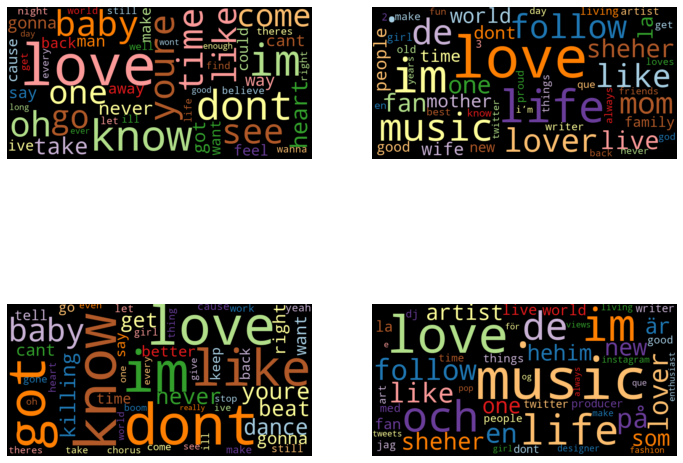

In [20]:
plt.figure(figsize=(12,10))
plt.subplot(2,2,1)
wordcloud(count_words(lyrics_data.loc[lyrics_data['artist'] == artist1])['freq'], max_words=50)
plt.subplot(2,2,2)
wordcloud(count_words(twitter_data.loc[twitter_data['artist'] == artist1])['freq'], max_words=50)
plt.subplot(2,2,3)
wordcloud(count_words(lyrics_data.loc[lyrics_data['artist'] == artist2])['freq'], max_words=50)
plt.subplot(2,2,4)
wordcloud(count_words(twitter_data.loc[twitter_data['artist'] == artist2])['freq'], max_words=50)

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: A lot of common words and frequencies of such words accross the different artists' corpora. The difference mainly is the ranking of those common words in relation to each other.

Saved functions for later. Ignore me.

In [ ]:
#these veriations return a dict or a paired list of words and count.
def computeIDF(documents):
    import math
    N = len(documents)
    
    idfDict = dict.fromkeys(documents[0].keys(), 0)
    for document in documents:
        for word, val in document.items():
            if val > 0:
                idfDict[word] += 1
    
    for word, val in idfDict.items():
        idfDict[word] = math.log(N / float(val))
    return idfDict

# def computeTFIDF(tfBagOfWords, idfs):
#     tfidf = {}
#     for word, val in tfBagOfWords.items():
#         tfidf[word] = val * idfs[word]
#     return tfidf
def nFindWords(bagOfWords):
    numOfWords = dict.fromkeys(uniqueWords, 0)
    for word in bagOfWords:
        numOfWords[word] += 1
    return numOfWords

# def findWords1(bagOfWords, n):
#     #sorted list of word counts
#     #wordCountSorted = sorted((Counter(tmpTwitList1).most_common()).items(), key=lambda x : x[1], reverse=True)
#     wordCountSorted = dict(Counter(bagOfWords).most_common())
#     nCounted = {}
#     for key, value in wordCountSorted.items():
#         if (value >= n):
#             nCounted[key] = value
#     return nCounted
def findWords2(bagOfWords, n):
    #sorted list of word counts
    #wordCountSorted = sorted((Counter(tmpTwitList1).most_common()).items(), key=lambda x : x[1], reverse=True)
    wordCountSorted = Counter(bagOfWords).most_common()
    nCounted = []
    for key, value in wordCountSorted:
        if (value >= n):
            nCounted.append([key, value])
    return nCounted

#Find token that occurs at least n times in each corpora.
#This only returns the words/tokens
def findWords3(bagOfWords, n):
    #sorted list of word counts
    #wordCountSorted = sorted((Counter(tmpTwitList1).most_common()).items(), key=lambda x : x[1], reverse=True)
    wordCountSorted = Counter(bagOfWords).most_common()
    nCounted = []
    for word, count in wordCountSorted:
        if (count >= n):
            nCounted.append(word)
    return nCounted

dictnWordsTwit1 = nFindWords(tmpTwitList1, 5)
dictnWordsTwit2 = nFindWords(tmpTwitList2, 5)
dictnWordsLyrics1 = nFindWords(tmpLyricList1, 5)
dictnWordsLyrics2 = nFindWords(tmpLyricList2, 5)

nWordsTwit1 = findWords3(tmpTwitList1, 5)
nWordsTwit2 = findWords3(tmpTwitList2, 5)
nWordsLyrics1 = findWords3(tmpLyricList1, 5)
nWordsLyrics2 = findWords3(tmpLyricList2, 5)

#Get a list of words with >n counts that exist in both corpora
#shared_keys = dict_of_dicts_a.keys() & dict_of_dicts_b.keys() # how to combine keys, but not needed
uniqueWordsTwitter = set(tmpTwitList1).intersection(set(tmpTwitList2))
uniqueWordsLyrics =set(tmpLyricList1).intersection(set(tmpLyricList2))

#show top and bottom 10 word counts
#This was a test to make sure only words counted n re more times are saved
nWordsTwit1 = findWords2(tmpTwitList1, 5)
nWordsTwit1[0:9] ,nWordsTwit1[-11:-1] , len(uniqueWordsTwitter), len(uniqueWordsLyrics)